**извлечение признаков из текста на естественном языке**

word2vec : skip-gram


Евгений Борисов <esborisov@sevsu.ru>

---

In [1]:
import re
import gzip
import numpy as np
from numpy import random as rng

## загружаем текст 

In [2]:
with gzip.open('../data/lobas-taxisty.txt.gz','rt') as f: 
    text = f.read()[654:]  # ...и выкидываем заголовок
print('символов:%i\n'%(len(text)))
print(text[:327].strip())

символов:601090

Вы прилетели в Нью-Йорк и остановились в одном из отелей, глядящих окнами на Центральный парк. Наутро по приезде вы вышли из отеля, вдохнули полной грудью очищенный зеленью парка воздух и, взглянув на часы, - пора было начинать хлопотливый день, - направились к первому из таксомоторов, выстроившихся вереницей у подъезда.


## выполняем токенизацию

In [3]:
from nltk import __version__ as nltk_version
print('nltk version:',nltk_version)

nltk version: 3.7


In [4]:
from random import sample

from razdel import sentenize
from razdel import tokenize

text = [ [ t.text.lower() for t in tokenize(s.text) ] for s in sentenize(text) ]

print('предложений: %i\n'%(len(text)))
display( sample(text,5) )

предложений: 7350



[['я',
  'кружил',
  'и',
  'кружил',
  'по',
  'пустому',
  'аэропорту',
  ',',
  'а',
  'руки',
  '-',
  'тряслись',
  ';',
  'я',
  'не',
  'мог',
  'прийти',
  'в',
  'себя',
  '.'],
 ['как-то',
  'поздним',
  'вечером',
  'на',
  'злополучном',
  'углу',
  'парк-авеню',
  'и',
  'сорок',
  'второй',
  'улицы',
  ',',
  'где',
  'получил',
  'я',
  'повестку',
  'в',
  'уголовный',
  'суд',
  '(',
  'автобусы',
  'не',
  'только',
  'увозят',
  'оттуда',
  'пассажиров',
  'в',
  'аэропорты',
  ',',
  'но',
  'и',
  'привозят',
  'их',
  'туда',
  'же',
  '-',
  'из',
  'аэропортов',
  ')',
  ',',
  'сел',
  'в',
  'мой',
  'кэб',
  'седой',
  'человек',
  'с',
  'потертым',
  'чемоданчиком',
  ',',
  'с',
  'которого',
  'свисала',
  'бирка',
  '"',
  'британские',
  'авиалинии',
  '"',
  ',',
  'и',
  'назвал',
  'адрес',
  '-',
  'где-то',
  'рядом',
  'с',
  'карнеги-холл',
  '.'],
 ['-', 'видите', 'ли', ',', 'я', 'в', 'такси', 'недавно', '.'],
 ['"',
  'хилтона',
  '"',
  ',',


In [5]:
# from random import sample
# from nltk.tokenize import sent_tokenize as nltk_sentence_split
# from nltk.tokenize import word_tokenize as nltk_tokenize_word
# from nltk.corpus import stopwords as nltk_stopwords

# stopwords = set() # set(nltk_stopwords.words('russian')) 

# text = [ 
#     [ 
#      t.lower() 
#      for t in nltk_tokenize_word(s) 
#      if re.match(r'[а-я -]+',t.lower()) and len(t)>1 
# #      if not( (t.lower() in stopwords) or (len(t)<3) ) 
#     ] # разбиваем предложения на слова
#     for s in nltk_sentence_split(text) # режем текст на отдельные предложения
# ]

# print('предложений: %i\n'%(len(text)))
# sample(text,5)

In [6]:
# собираем словарь
words = set.union( *[ set(s) for s in text ] )
vocab =  { w:i for i,w in enumerate(sorted(words)) }
n_words = len(vocab) # количество слов в словаре
print( "размер словаря: %i слов" % n_words )
sample(sorted(words),9)

размер словаря: 22477 слов


['авиалиний',
 'спине',
 'окриков',
 'снимали',
 'мини-парк',
 'декларацию',
 'безупречности',
 'коровий',
 'ожидании']

## собираем контексты

In [7]:
# from nltk.util import bigrams
from nltk.util import ngrams as nltk_ngrams

# вынимаем все n-gram из текста
ngram_len = 5

text_ngrams = [ 
    ngram 
    for s in text if len(s)>ngram_len
    for ngram in nltk_ngrams(s,ngram_len) 
]
print('количество n-gram: %i'%(len(set(text_ngrams))))
sample(text_ngrams,5)

количество n-gram: 87526


[('i', 'love', 'money', '!', '13'),
 ('ангел', 'стал', 'давать', 'аэропорты', '!'),
 ('никак', 'не', 'находила', 'себе', 'места'),
 (',', 'чтоб', 'не', 'лопасть', 'впросак'),
 ('точно', 'так', 'же', ':', 'остановился')]

In [8]:
# text_ngrams = sample(text_ngrams,1_000) # сокращаем учебный набор для ускорения процесса
text_ngrams = sample(text_ngrams,10) # сокращаем учебный набор для ускорения процесса

### кодируем слова

In [9]:
T = np.array([ [ vocab[w] for w in ngrams ] for ngrams in text_ngrams ]) # кодируем слова
wn = ngram_len//2
W = T[:,wn] # коды слов
C = np.delete(T,wn,axis=1) # коды слов контекста

assert len(C) == len(W)

C.shape, W.shape

((10, 4), (10,))

In [10]:
del text_ngrams
del text
del T

In [11]:
# # унитарное кодирование слов (one-hot-encoding)
E = np.eye(n_words,dtype=np.int8)
Wbin = np.vstack([ E[c] for c in W ])
Cbin = np.vstack([ np.vstack([ E[c] for c in Ci ])[np.newaxis,:] for Ci in C ]) 

Cbin.shape, Wbin.shape

((10, 4, 22477), (10, 22477))

In [12]:
del W
del C

## строим модель Skip-Gram

In [13]:
# будем по контексту предсказывать слово

In [14]:
# ф-ция активации скрытого слоя - линейная
# def act(s): return s

# ф-ция активации выходного слоя
def softmax(s): 
    e = np.exp(s)
    return e/e.sum(axis=1).reshape(s.shape[0],1)

In [15]:
def w2v_step(W,Vi,Vo):
    H = W.dot(Vi) # значения скрытого слоя
    U = H.dot(Vo) # состояния выходного слоя
    O = softmax(U) # выход сети
    return H,U,O

Функция потери

$$E = \left| \sum\limits_i\log\left( \sum\limits_k \exp(U_{ik}) \right) - \sum\limits_i\sum\limits_k\sum\limits_j (U_{ik} * Q_{ijk}) \right| $$


$U_{ik}$ состояние k-того нейрона выходного слоя для слова $i$     
$Q_{ij}$ слово $j$ контекста слова $i$   
где ∗ - операция поэлементного умножения векторов

In [16]:
def w2v_loss(U,C):
    n,cws,v = C.shape 
    # количество примеров
    # размер окна контекста   
    # количество слов в словаре

    Us = np.log( np.exp(U).sum(axis=1) ).sum()

    Uo = 0.0
    for i in range(cws): # для всех слов контекста
        Ci = C[:,i,:].reshape([n,v]) # набор слов контекста i
        Uo += (U*Ci).sum() # значения выходного слоя для слов x контекста i

    return np.abs(Us-Uo)/n

In [17]:
def w2v_grad(C,W,H,O,Vo):
    n,cws,v = C.shape
        # количество примеров
        # размер окна контекста   
        # количество слов в словаре

    gVi = gVo = 0.0 

    for i in range(cws):
        Ci = C[:,i,:].reshape([n,v]) # слово i контекста
        D = O - Ci # ошибка на слове контекста i
        gVo += D.T.dot(H).T
        gVi += W.T.dot(D).dot(Vo.T)

    return gVi,gVo

In [18]:
def w2v_weigth_norm(v,w):
    nn = np.linalg.norm( np.hstack([ v.flatten(), w.flatten() ]) )
    #nn = np.abs( np.hstack([ v.flatten(), w.flatten() ]) ).max()
    return (v/nn,w/nn) if nn!=0.0 else (v,w)

### обучаем модель

In [19]:
n = Wbin.shape[1] # количество слов в словаре
k = 30 # размер скрытого слоя H
Vi = rng.normal(scale=.01,size=(n,k))
Vo = rng.normal(scale=.01,size=(k,n))

In [20]:
%%time

from tqdm.notebook import tqdm

a = .91 # скорость обучения
er = [1e10]
n_epoch = 10

for _ in (pbar:=tqdm(range(n_epoch))):
    H,U,O = w2v_step(Wbin,Vi,Vo) # вычисляем состояния слоёв и выход
    er.append(w2v_loss(U,Cbin)) # вычисляем ошибку
    pbar.set_postfix({'error':er[-1]})
    if er[-1]>er[-2]: 
        Vi, Vo = Vi_old, Vo_old
        break
        
    gVi, gVo = w2v_grad(Cbin,Wbin,H,O,Vo) # вычисляем градиент ф-ции потери
    gVi,gVo = w2v_weigth_norm(gVi,gVo) # нормируем значения градиента
    Vi_old, Vo_old =  Vi, Vo # сохраняем старые веса
    Vi,Vo = Vi-a*gVi, Vo-a*gVo # корректируем веса

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 4min 3s, sys: 2min 40s, total: 6min 43s
Wall time: 3min 29s


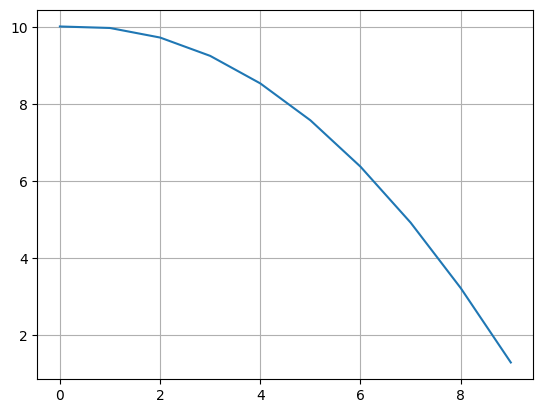

In [21]:
from matplotlib import pyplot as plt

er=er[1:]
plt.plot(er)
plt.grid()
plt.show()

## оцениваем результат

In [22]:
from sklearn.metrics.pairwise import pairwise_distances

In [23]:
D = pairwise_distances(Vi) # матрица расстояний
R = np.argsort(D) # номера слов в порядке увеличения расстояния

In [24]:
from numpy import random as rng

In [25]:
vocab_ = { v:k for k,v in vocab.items() } # нумеруем слов в словаре

nn = rng.permutation(len(vocab))[:20] # выбираем случайно N слов

# для выбранных слов печатаем близкие по w2v
{ vocab_[i] : [ vocab_[j] for j in  R[i,1:5]  ] for i in nn }

{'болезненным': ['пачка', 'доподлинно', 'закатилась', 'рубаху'],
 'фуражку': ['сириец', 'подчеркнуто', 'погладить', 'взлетах'],
 'еженедельного': ['ощущение', 'ранит', 'автомобилистами', 'понедельника'],
 'нюанс': ['раненную', 'подавил', 'пассажирский', 'хозяйки'],
 'уговор': ['повышенные', 'мерзости', 'установку', 'ляпни'],
 'последить': ['повторяя', 'девочек', 'крутя', 'часок'],
 'удостоверении': ['термоса', 'пачка', 'бесповоротно', 'ми'],
 'сантехнику': ['сдерживая', 'тупостью', 'постарше', 'детский'],
 'миллионером': ['сожженный', 'плексиглас', 'приближением', 'пронзающей'],
 'определенно': ['солнца', 'стажем', 'встречались', 'экспериментальный'],
 'яркие': ['светофоре', 'напечатано', 'шевроле', 'дубровник'],
 'росы': ['вдвоем', 'стерва', 'визитную', 'ящиках'],
 'поговорили': ['истории', 'плитами', 'допрос', 'задето'],
 'ресторанчики': ['министры', 'кушат', 'скромную', 'запас'],
 'прочитаешь': ['тягостная', 'регулировщицы', 'коробке', 'руками'],
 'устно': ['по-американски', 'ручонк